<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Utilities" data-toc-modified-id="Utilities-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Utilities</a></span></li><li><span><a href="#Overview" data-toc-modified-id="Overview-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Projective-Transform-and-Warping" data-toc-modified-id="Projective-Transform-and-Warping-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Projective Transform and Warping</a></span></li><li><span><a href="#Scale-Invariant-Feature-Transform-(SIFT)" data-toc-modified-id="Scale-Invariant-Feature-Transform-(SIFT)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Scale Invariant Feature Transform (SIFT)</a></span><ul class="toc-item"><li><span><a href="#SIFT-in-Theory" data-toc-modified-id="SIFT-in-Theory-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>SIFT in Theory</a></span></li><li><span><a href="#SIFT-in-Practice" data-toc-modified-id="SIFT-in-Practice-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>SIFT in Practice</a></span></li></ul></li><li><span><a href="#Matching-Descriptors" data-toc-modified-id="Matching-Descriptors-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Matching Descriptors</a></span></li><li><span><a href="#Random-Sample-Concensus-(RANSAC)" data-toc-modified-id="Random-Sample-Concensus-(RANSAC)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Random Sample Concensus (RANSAC)</a></span><ul class="toc-item"><li><span><a href="#Ransac-for-Line-Fitting" data-toc-modified-id="Ransac-for-Line-Fitting-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Ransac for Line Fitting</a></span></li><li><span><a href="#Find-a-Perspective-Transform-using-Ransac" data-toc-modified-id="Find-a-Perspective-Transform-using-Ransac-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Find a Perspective Transform using Ransac</a></span></li></ul></li><li><span><a href="#Stitching-it-all-together" data-toc-modified-id="Stitching-it-all-together-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Stitching it all together</a></span></li><li><span><a href="#A-Better-Stitch-(Bonus-Points)" data-toc-modified-id="A-Better-Stitch-(Bonus-Points)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>A Better Stitch (Bonus Points)</a></span></li><li><span><a href="#Stitching-your-own-Images-(Bonus-Points)" data-toc-modified-id="Stitching-your-own-Images-(Bonus-Points)-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Stitching your own Images (Bonus Points)</a></span></li></ul></div>

# CV LabExercise: Image Stitching using SIFT

## Initialization

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import wget
from skimage.transform import warp
import scipy
import cv2
from matplotlib.patches import ConnectionPatch

This week, we are working with SIFT. For this we need the right version of the `opencv` package. Did you do assignment 0 of week 1, about installing the correct version? If not, go do that now. (If you are on Python 3.7, try `python3 -m pip install --user opencv-contrib-python-nonfree`. If you are on Python 3.8, try to get your notebook running on 3.7 or below.)

Hidden in this cell are some $\LaTeX$ macros
$\newcommand{\v}[1]{\mathbf #1}$
$\newcommand{\hv}[1]{\widetilde{\mathbf #1}}$
$\newcommand{\setR}{\mathbb R}$
$\newcommand{\T}{^\top}$
$\newcommand{\inv}{^{-1}}$
$\newcommand{\pfrac}[2]{\frac{\partial #1}{\partial #2}}$

## Utilities

In this section some code that is needed later on this exercise. Make sure this is code is run before using it.

In [124]:
def imshow_row(imttllist, axs=False):
    n = len(imttllist)
    for i, imttl in enumerate(imttllist):
        if imttl is None:
            continue
        im, ttl = imttl
        plt.subplot(1,n,i+1)
        plt.imshow(im, cmap='gray')
        if not axs:
            plt.axis('off')
        plt.title(ttl)
        
def draw_keypoints(kps, nkps=None, ax=None, marker='x', 
                   marker_size=10, scale_and_orientation=True):
    if ax is None:
        ax = plt.gca()
    if nkps is None:
        nkps = len(kps)
    xs = [kp.pt[0] for kp in kps]
    ys = [kp.pt[1] for kp in kps]
    ax.scatter(xs, ys, marker=marker)
    if scale_and_orientation:
        for kp in kps[:nkps]:
            x, y = kp.pt
            r = kp.size / 2
            angle = kp.angle/2/np.pi
            ax.add_artist(plt.Circle((kp.pt), kp.size/2, 
                                     color='green', fill=False))
            ax.add_artist(plt.Arrow(x, y, r*np.cos(angle), 
                                    r*np.sin(angle), color='red'))
            


def draw_matches(f1, kps1, f2, kps2, matches, 
                 horizontal=True, figsize=(15,15)):
    if horizontal:
        fig, axs = plt.subplots(1,2, figsize=figsize)
    else:
        fig, axs = plt.subplots(2,1, figsize=figsize)
    
    axs[0].imshow(f1)
    axs[1].imshow(f2)
    
    # get the indexes of the matches
    idx1 = [m.queryIdx for m in matches]
    idx2 = [m.trainIdx for m in matches]
    
    xs1 = [kps1[i].pt[0] for i in idx1]
    ys1 = [kps1[i].pt[1] for i in idx1]
    xs2 = [kps2[i].pt[0] for i in idx2]
    ys2 = [kps2[i].pt[1] for i in idx2]
    
    
    for x1, y1, x2, y2 in zip(xs1, ys1, xs2, ys2):
        con = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA="data", coordsB="data",
                      axesA=axs[0], axesB=axs[1], color='g')
        axs[1].add_artist(con)            


## Overview

The goal of this project is to write the software to stitch two or more images of the same scene together. In this report we describe the process of stitching only two images together. The basic steps of the algorithm are:
 
1. **Locate keypoints** in both images. A keypoint is defined by its position $(x,y)$ in the image, the scale $s$ at which it is detected, its orientation $\theta$ and a descriptor $\v d$ that characterizes what the image looks like in the neighborhood of the keypoint.

1. **Match the keypoints** in both images. A pair $((x,y,\theta,\v d), (x',y',\theta',\v d')$ (the primed keypoint is in image 2, the other keypoint is in image 1) matches when $\|\v d - \v d'\|$ is small enough to conclude that image 1 around point $(x,y)$ is visually (almost) equal to image 2 around point $(x', y')$.

1. **Estimate the transformation** $P$ that maps points in image 1 to the corresponding points in image 2. Because not all found point matches from step 2 are correct we need a robust estimation procedure that is capable of selecting those matching pairs that are indeed related through the transform $P$. For this we will use the RANSAC procedure.

1. **Warp** both images to a common coordinate system, and display the result.

This is an assignment in which the SIFT part can be used from OpenCV (it would be too big), but RANSAC you are asked to implement yourself (not too hard, and instructive).

In this exercise we start with stitching two small views on Rembrandt's Nachtwacht into a common coordinate frame. The two images are stored as jpeg files on disk. So when reading these images they are represented as (M,N,3) shaped arrays of dtype=uint8. 

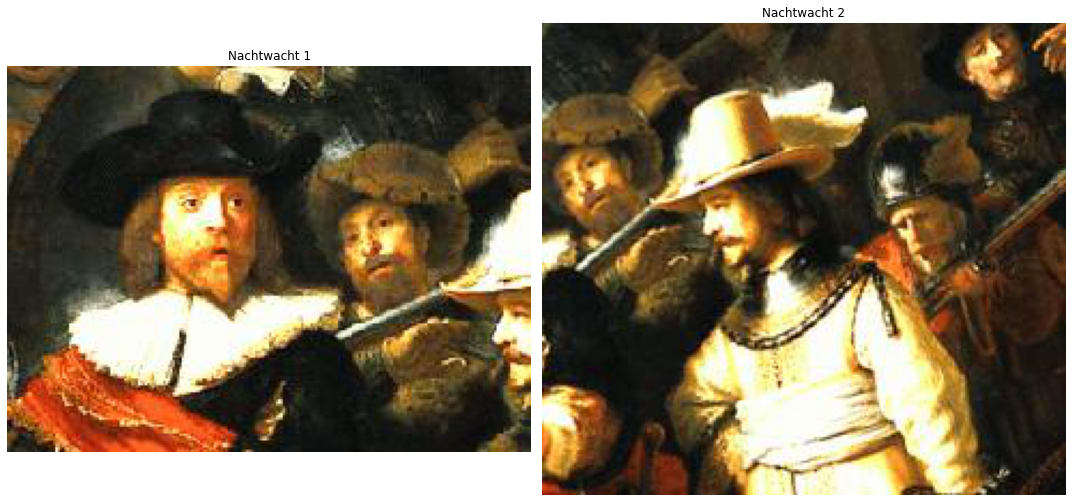

In [125]:
try:
    f1 = plt.imread('nachtwacht1.jpg')
except FileNotFoundError:
    wget.download("https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/nachtwacht1.jpg")
    f1 = plt.imread('nachtwacht1.jpg')
try:
    f2 = plt.imread('nachtwacht2.jpg')
except FileNotFoundError:
    wget.download("https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/nachtwacht2.jpg")
    f2 = plt.imread('nachtwacht2.jpg')
plt.figure(figsize=(15,15))
imshow_row([(f1, "Nachtwacht 1"),
            (f2, "Nachtwacht 2")])
plt.tight_layout()

Note that the scale of both images is different and also the orientation is slightly different. In fact, it will turn out that we really need a projective transform to relate the coordinate frames of these two images.

In this exercise we will proceed as follows:

1. Using 4 and 6 point correspondences in the images we test your   
   implementation of ``projective_transform_matrix``

1. Instead of manually selected point correspondences in both images 
   we will use SIFT and RANSAC to find the point correspondences 
   while at the same time estimating the projective transform.
   
   1. For SIFT we will use the OpenCV version, and
   
   1. For RANSAC you will have to implement your own version.
   
1. Then you have to make an image filled with zeros and warp both   
   nachtwacht images to the coordinate frame of the resulting image. 
   The new image should contain the two nachtwacht images completely 
   (note that this last requirement is not met within the first part 
   of this exercise)
      

## Projective Transform and Warping

In the nachtwacht1 and nachtwacht2 image we have manually picked 4 corresponding points, these are collected in the arrays ``xy`` and ``xaya``.

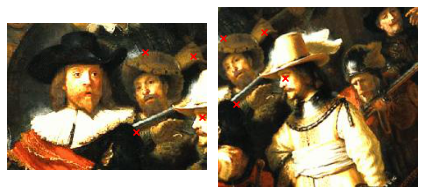

In [126]:
xy = np.array([[ 157, 32],
               [ 211, 37],
               [ 222,107],
               [ 147,124]])
xaya = np.array([[  6, 38],
                 [ 56, 31],
                 [ 82, 87],
                 [ 22,118]])
plt.subplot(1,2,1)
plt.imshow(f1)
plt.scatter(xy[:,0], xy[:,1], marker='x', color='r')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(f2)
plt.scatter(xaya[:,0], xaya[:,1], marker='x', color='r')
plt.axis('off')
plt.tight_layout()

From these point correpondences you can calculate the projective transform $P$ that maps coordinates in the first image to the corresponding coordinates in the right image. First repeat your ``projective_transform_matrix`` function from a previous lab below:

In [127]:
def projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4):
    M = np.array([
         [x1[0], x1[1], 1, 0, 0, 0, -xa1[0]*x1[0], -xa1[0]*x1[1], -xa1[0]], \
         [0, 0, 0, x1[0], x1[1], 1, -xa1[1]*x1[0], -xa1[1]*x1[1], -xa1[1]], \
         [x2[0], x2[1], 1, 0, 0, 0, -xa2[0]*x2[0], -xa2[0]*x2[1], -xa2[0]], \
         [0, 0, 0, x2[0], x2[1], 1, -xa2[1]*x2[0], -xa2[1]*x2[1], -xa2[1]], \
         [x3[0], x3[1], 1, 0, 0, 0, -xa3[0]*x3[0], -xa3[0]*x3[1], -xa3[0]], \
         [0, 0, 0, x3[0], x3[1], 1, -xa3[1]*x3[0], -xa3[1]*x3[1], -xa3[1]], \
         [x4[0], x4[1], 1, 0, 0, 0, -xa4[0]*x4[0], -xa4[0]*x4[1], -xa4[0]], \
         [0, 0, 0, x4[0], x4[1], 1, -xa4[1]*x4[0], -xa4[1]*x4[1], -xa4[1]]])
    
    U, S, V_T = np.linalg.svd(M)
    P = V_T[-1]
    return np.array([P[:3],P[3:6],P[6:]])


We will also find some use for the ``e2h`` and ``h2e`` functions. Just copy the code from a previous exercise.

In [128]:
def e2h(x):
    if len(np.shape(x)) != 1:
        return np.append(x, [np.ones(x.shape[1])], axis=0)
    else:
        return np.append(x, [1], axis=0)
    
def h2e(tx):
    return tx[:-1]/tx[-1]

In [129]:
# Note: these are the same tests as previously. They are just for checking that your copy/paste went correctly.
# You do not get points for these. There are no hidden tests in this cell.

assert type(e2h(np.array([1,2]))) == np.ndarray, "Your functions should return numpy arrays."
hom_v = e2h(np.array([1, 2]))
assert (hom_v[:2]/hom_v[-1] == np.array([1, 2])).all()
hom_v = e2h(np.array([0.5, 5.3, 2.1]))
assert (hom_v[:3]/hom_v[-1] == np.array([0.5, 5.3, 2.1])).all(), \
    "Does e2h work for arbitrary length vectors?"
hom_mat = e2h(np.array([[1, 2], [3, 4]]))
assert (hom_mat/hom_mat[2, :] == np.array([[1,2], [3,4], [1,1]])).all(), \
    "Does e2h work for multiple vectors in a matrix?"
assert (h2e(np.array([3, 2, 1])) == np.array([3,2])).all()
assert (h2e(np.array([1, 2, 4])) == np.array([0.25, 0.5])).all(), \
    "A vector in homogeneous coordinates does not need to end in a 1."
assert (h2e(np.array([[1, 2], [3, 4], [1, 4]])) == np.array([[1, 0.5], [3, 1]])).all(), \
    "Does h2e work for multiple vectors in a matrix?"

matrices = [np.array([[1,2,3],[4,1,3]]), np.array([[-1,30,-20,12], [7,8,10,0],[1,2,3,4]])]

for matrix in matrices:
    assert (h2e(e2h(matrix)) == matrix).all()
    assert (h2e(e2h(h2e(matrix))) == h2e(matrix)).all()


x1 = xa1 = np.array([3, 4])
x2 = xa2 = np.array([1, 6])
x3 = xa3 = np.array([-1, 4])
x4 = xa4 = np.array([-2, -2])
mat = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)
assert type(mat) == np.ndarray, "Your functions should return numpy arrays."
assert np.isclose(mat/mat[0][0], np.eye(3)).all()

x1 = np.array([1, 0])
x2 = np.array([0, 0])
x3 = np.array([0, 1])
x4 = np.array([2, 2])
xa1 = np.array([1, 1])
xa2 = np.array([0, 1])
xa3 = np.array([1, 2])
xa4 = np.array([4, 3])
mat = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)
assert np.isclose(mat/mat[0][0], 
                  np.array([[1., 1., 0.], [0., 1., 1.], [0., 0., 1.]])).all()

x1 = np.array([-1.07940287, -0.26676884])
x2 = np.array([-1.94446771,  0.99136051])
x3 = np.array([ 0.53195084, -0.92345123])
x4 = np.array([-2.0096041,  -0.31318524])
xa1 = np.array([-0.72127465,  1.25197087])
xa2 = np.array([0.31686279, 0.83655885])
xa3 = np.array([ 1.35574341, -0.74688174])
xa4 = np.array([2.1325028, -0.01398243])
mat = projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4)
assert np.isclose(mat/mat[0][0],
                  np.array([[1.        , 1.79635391, 1.23567397],
                            [0.48647871, 2.13857992, 1.65616461],
                            [1.00421514, 3.02375251, 2.338331  ]])).all()

In [130]:
P = projective_transform_matrix(xy[0], xy[1], xy[2], xy[3],
                           xaya[0], xaya[1], xaya[2], xaya[3])

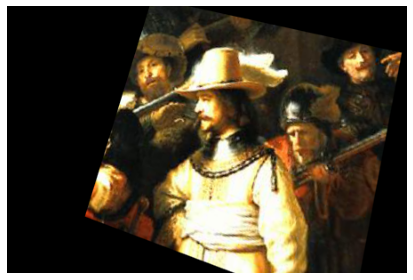

In [131]:
f_stitched = warp(f2, P, output_shape=(300,450), preserve_range=True).astype(np.uint8)
plt.imshow(f_stitched);
plt.axis('off');
plt.tight_layout()

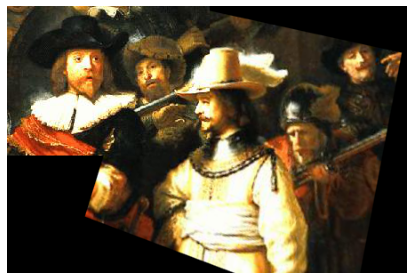

In [132]:
M, N = f1.shape[:2]
f_stitched[:M, :N, :] = f1
plt.imshow(f_stitched);
plt.axis('off');
plt.tight_layout()

Be sure to understand what is going on in the code above. Can you explain why you didn't need the inverse of $P$ in the warp function?

Note that the stitching is not exactly perfect. You can clearly see the border of the first image. The reason is that our hand-picked points weren't perfect matches for the two images. We can improve by using more than four points to get a best fit for the handpicked correspondences. 

You have to change your ``projective_transform_matrix`` to be able to do the estimation of the projection matrix in case more than the minimal 4 point correspondences are given. Below we give 6 point correspondences:

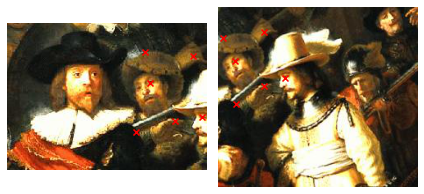

In [133]:
xy6 = np.array([[ 157, 32],
               [ 211, 37],
               [ 222,107],
               [ 147,124],
               [ 163, 68],
               [ 191,111]])
xaya6 = np.array([[  6, 38],
                 [ 56, 31],
                 [ 82, 87],
                 [ 22,118],
                 [ 21, 66],
                 [ 56, 96]])
plt.subplot(1,2,1)
plt.imshow(f1)
plt.scatter(xy6[:,0], xy6[:,1], marker='x', color='r')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(f2)
plt.scatter(xaya6[:,0], xaya6[:,1], marker='x', color='r')
plt.axis('off')
plt.tight_layout()

Below you have to adapt the code from a previous lab exercise to be able to deal with more than 4 point correspondences. (3pt)

In [134]:
# Note: we are overwriting the function `projective_transform_matrix` here.

def projective_transform_matrix(xy, xaya):
    dim = len(xy)
    M = []
    for i in range(dim):
        M.append([xy[i][0], xy[i][1], 1, 0, 0, 0, -xaya[i][0]*xy[i][0], -xaya[i][0]*xy[i][1], -xaya[i][0]])
        M.append([0, 0, 0, xy[i][0], xy[i][1], 1, -xaya[i][1]*xy[i][0], -xaya[i][1]*xy[i][1], -xaya[i][1]])
    
    U, S, V_T = np.linalg.svd(M)
    P = V_T.T[:,-1]
    P = P.reshape(3,3)
    return P 
# np.array([P[:3],P[3:6],P[6:]])

In [135]:
x = xa = np.array([[3, 4], [1, 6], [-1, 4], [-2, -2]])
mat = projective_transform_matrix(x, xa)
assert type(mat) == np.ndarray, "Your functions should return numpy arrays."
assert np.isclose(mat/mat[0][0], np.eye(3)).all()

x = np.array([[1, 0], [0, 0], [0, 1], [2, 2]])
xa = np.array([[1, 1], [0, 1], [1, 2], [4, 3]])
mat = projective_transform_matrix(x, xa)
assert np.isclose(mat/mat[0][0], 
                  np.array([[1., 1., 0.], [0., 1., 1.], [0., 0., 1.]])).all()

# Using 5 points with small errors.
eps = 1e-8
x = np.array([[1, 0], [0, 0], [0, 1], [2, 2], [4, 3]])
xa = np.array([[1, 1+eps], [0, 1-eps], [1, 2+eps], [4, 3-eps], [7, 4+eps]])
mat = projective_transform_matrix(x, xa)
assert np.isclose(mat/mat[0][0], 
                  np.array([[1., 1., 0.], [0., 1., 1.], [0., 0., 1.]])).all()

# More points.
x = np.array([[-0.30099881,  0.34786734],
       [-0.43573294,  0.64231348],
       [-1.28532622,  1.13860487],
       [ 0.54744592,  0.51493255],
       [-0.20087976,  0.18980669],
       [-1.27066563, -0.20241131],
       [-0.64972417, -2.02646797],
       [-2.38189517, -0.1663487 ]])
xa = np.array([[ 0.369618  ,  0.67714101],
       [ 1.72259747, -0.04050429],
       [ 2.22190863, -1.06356781],
       [ 0.80900945, -2.48119838],
       [-0.53911635,  1.2555933 ],
       [ 0.07221467, -0.24165753],
       [-2.37579957,  0.87320773],
       [ 0.47265383, -0.59226317]])
mat = projective_transform_matrix(x, xa)
assert np.isclose(mat/mat[0][0],
                 np.array([[ 1.        , -1.8574528 ,  0.77686397],
                           [-1.0861612 ,  0.63049228, -0.85821791],
                           [ 1.01049866,  0.34736811, -0.27737639]])).all()

In [136]:
P6 = projective_transform_matrix(xy, xaya)

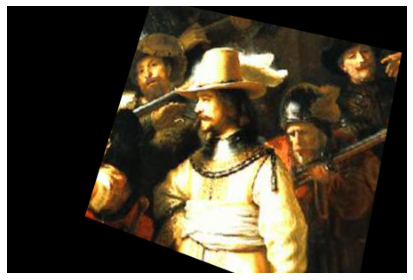

In [137]:
f_stitched6 = warp(f2, P6, output_shape=(300,450))
plt.imshow(f_stitched6);
plt.axis('off');
plt.tight_layout()

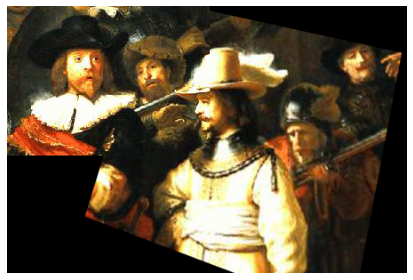

In [138]:
M, N = f1.shape[:2]
f_stitched6[:M, :N, :] = f1/255.0 #rescaling f1 to play nice with the warp function
plt.imshow(f_stitched6);
plt.axis('off');
plt.tight_layout()

Note that even 6 point correspondences that are manually selected do not result in good result (look at the white hat at the border of both images). In the sequel of this lab exercise SIFT/RANSAC will be used to automatically find corresponding points in both images with much better accuracy leading to better stitching results.

## Scale Invariant Feature Transform (SIFT)

### SIFT in Theory

You have read the Lowe paper as the first part of this assignment, and in the process worked out some of its details. Here are question blocks in which you can report your answers.

**Questions.** (2pt each)

1. Scale space extrema are going to be detected by computing $D$ according to   
   Eq.1 (in Lowes paper). According to Lowe "the relationship between $D$ and 
   $\sigma^2 \nabla^2 G$ can be understood..." but he does not return to $D$. 
   Close the loop in his explanation yourself, explicitly.

1. Derive the following result explicitly (mathematically). 
   \begin{align}
   D(\hat{\v x}) = D + \tfrac{1}{2}\pfrac{D}{\v x}\T \hat{\v x}
   \end{align}
   The $\tfrac{1}{2}$ looks 
   like a typo but is not, make sure you get that factor right!
 
1. Page 16, line 12: what does he mean by “affine changes in illumination”?

1. Why does Lowe not just compute the ratio $r$ of eigenvalues on page 16 
   directly?
   
6. Researcher Lindeberg comments on Lowe that it is better to use    
   $Det(H)/(Tr(H)^2)$, which is the reciprocal of the measure that Lowe uses. Why would he recommend this? Give an example of a local neighborhood 
   in which this would work better.


1. D is defined as the difference of Gaussian function convolved with an image, or $D(x, y, \sigma) = (G(x, y, k \sigma) - G(x, y, \sigma)) * I(x,y)$
while $\sigma^2 \nabla^2 G$ describes the scale-normalized Laplacian of Gaussian, or $
\frac{G(x, y, k \sigma) - G(x, y, \sigma)}{k \sigma - \sigma}$
From these two equations the relationship between D and $\sigma^2 \nabla^2 G$ can easily be seen, D describes the Gaussian difference function between two given scales (sigma and sigma multiplied by k) when it has already been applied to an image, $\sigma^2 \nabla^2 G$
describes this same function, before it is used in convolution with an image, and normalized w.r.t the scale (sigma) and the factor k (which is used in determining which other scale the difference image is computed with).

2. According to the book, 
    \begin{align}
    D({\v x}) = D + \pfrac{D}{\v x}\T {\v x} + \tfrac{1}{2} {\v x}\T \pfrac{D^{2}}{\v x^{2}} {\v x}
    \end{align}
    \begin{align}
    \hat{\v x} = -\pfrac{D^{2}}{\v x^{2}}^{-1} \pfrac{D}{\v x}
    \end{align}
    substituting gives us
    \begin{align}
    D(\hat{\v x}) = D + \pfrac{D}{\v x}\T * (-\pfrac{D^{2}}{\v x^{2}}^{-1} \pfrac{D}{\v x}) + \tfrac{1}{2} (-\pfrac{D^{2}}{\v x^{2}}^{-1} \pfrac{D}{\v x})\T \pfrac{D^{2}}{\v x^{2}} * (-\pfrac{D^{2}}{\v x^{2}}^{-1} \pfrac{D}{\v x})
    \end{align}
    =
    \begin{align}
    D(\hat{\v x}) = D + \pfrac{D}{\v x}\T \hat{\v x} + \tfrac{1}{2} (-\pfrac{D^{2}}{\v x^{2}}^{-1} \pfrac{D}{\v x})\T \pfrac{D^{2}}{\v x^{2}} \hat{\v x}
    \end{align}
    =
    \begin{align}
    D(\hat{\v x}) = D + \pfrac{D}{\v x}\T \hat{\v x} - \tfrac{1}{2} \pfrac{D}{\v x}\T \pfrac{D^{2}}{\v x^{2}}^{-1} \pfrac{D^{2}}{\v x^{2}} \hat{\v x}
    \end{align}
    =
    \begin{align}
    D(\hat{\v x}) = D + \pfrac{D}{\v x}\T \hat{\v x} - \tfrac{1}{2} \pfrac{D}{\v x}\T \hat{\v x}
    \end{align}
    =
    \begin{align}
    D(\hat{\v x}) = D + \tfrac{1}{2} \pfrac{D}{\v x}\T \hat{\v x}
    \end{align}
3. 
'Affine' describes a relationship (between two images) being a transformation in scale, rotation or displacement. Therefore, 'affine changes in illumination' describe changes in light such as the angle at which it hits a certain object, or the intensity or origin point of light.

4.
Because that would require an unnecessary amount of computation, as is explained on page 12. Taking the eigenvalues would mean having to perform a number of operations on the Hessian matrices in order to get them, and then their ratio would still need to be taken. This way, only the matrices themselves are needed and their determinants and traces can be computed very easily and quickly, and their ratio provides the same use as the ratio between eigenvalues.

5. H is defined as the following 2x2 matrix of a certain pixel: 
    \begin{bmatrix}
    D_{xx} &D_{xy}\\
    D_{xy} & D_{yy}
    \end{bmatrix}
    The determinant of which is calculated using the following formula: $D_{xx} * D_{yy} - D_{xy}^{2}$
    This means that any time $D_{xx} * D_{yy} and D_{xy}^{2}$ are equal using the $(Tr(H)^2)/Det(H)$ formula will result in division by zero. A neighborhood where this could happen is one where the double derivative is the same in every direction, so for example in the middle of a homogeneously colored circle against a homogeneously colored background.

### SIFT in Practice

We will use the SIFT algorithm from OpenCV. A quite complex algorithm using quite some clever 'tricks-of-the-(computer vision)-trade'. In case you are interested look at the [source code](https://github.com/opencv/opencv_contrib/blob/master/modules/xfeatures2d/src/sift.cpp) (yes this is really how messy computer vision code can get if you want to squeeze out every last bit of performance from your computer).

OpenCV encodes a color pixel with a BGR triple of values whereas Matplotlib and skimage use RGB triplets. That is why in the code below you see the cryptic ``f1[:,:,::-1]`` indexing.

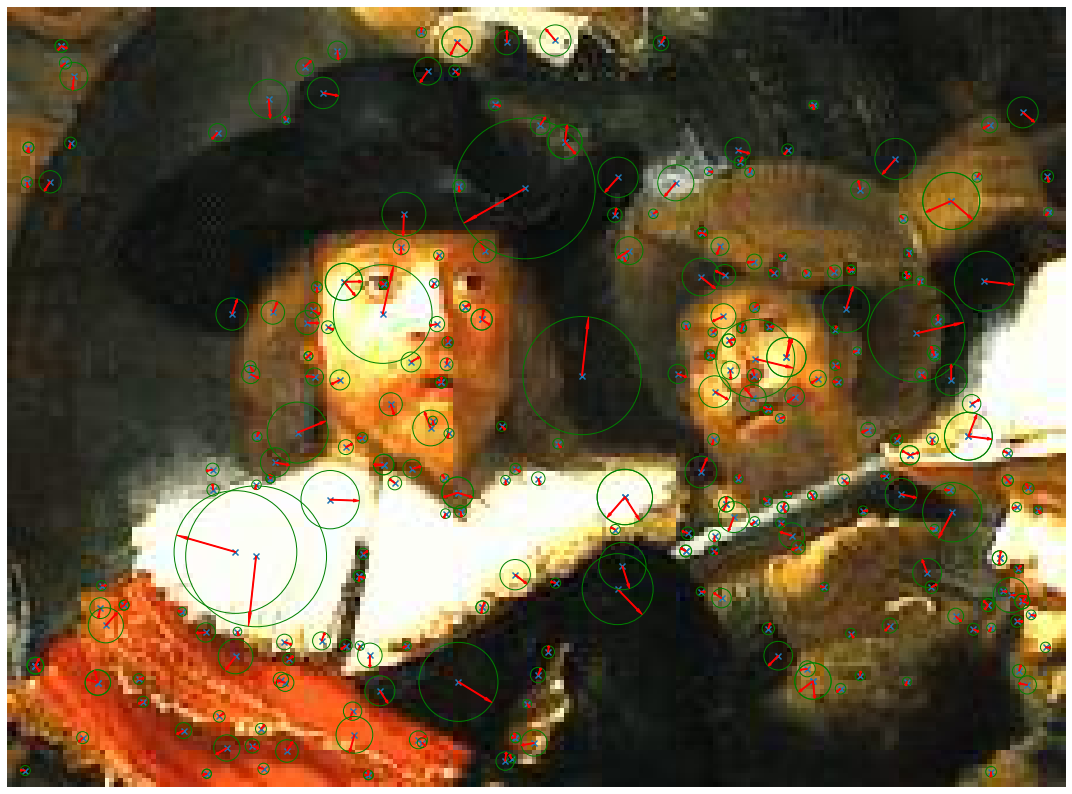

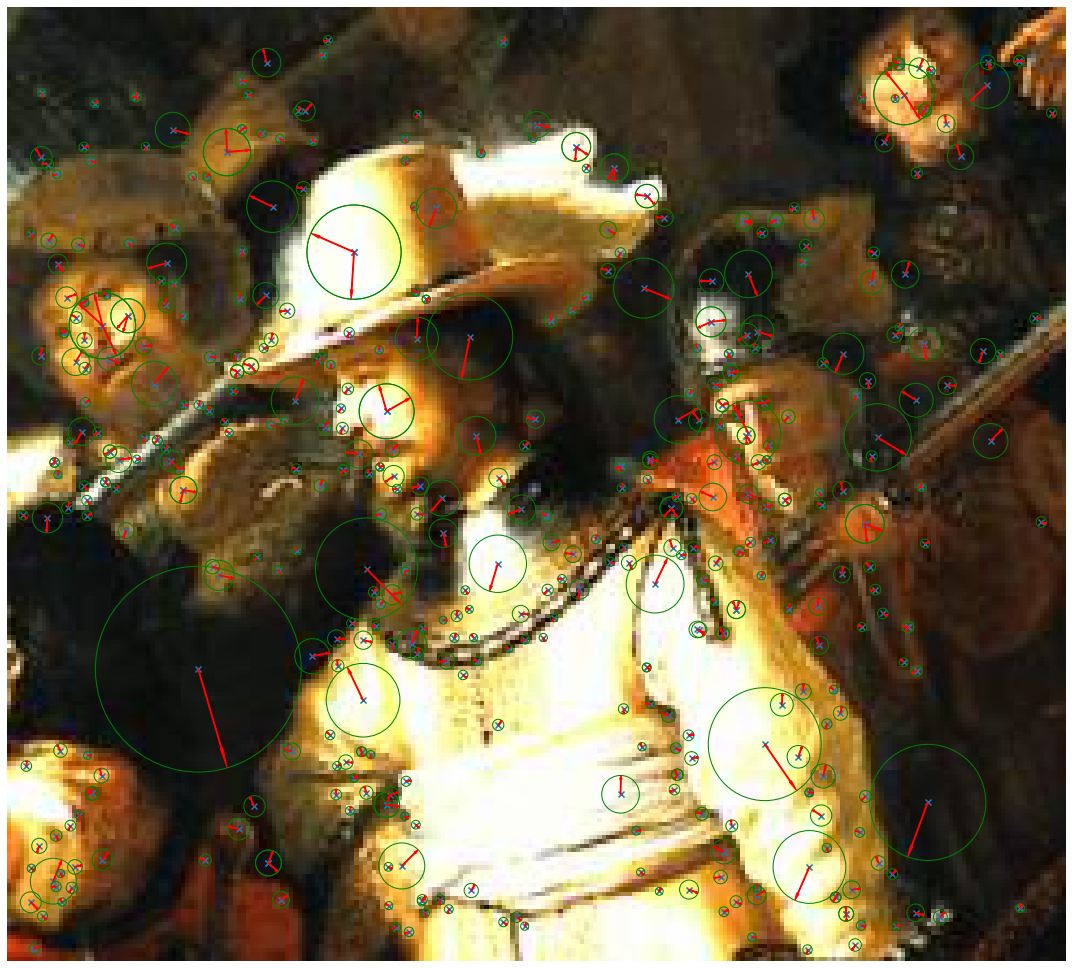

In [139]:
fd = cv2.xfeatures2d.SIFT_create()
kp1, d1 = fd.detectAndCompute(f1[:,:,::-1], None)
kp2, d2 = fd.detectAndCompute(f2[:,:,::-1], None)
plt.figure(figsize=(15,15))
plt.imshow(f1)
draw_keypoints(kp1)
plt.axis('off')
plt.tight_layout()
plt.figure(figsize=(15,15))
plt.imshow(f2)
draw_keypoints(kp2)
plt.axis('off')
plt.tight_layout()

**Question.** (2pt)

6. In the two images above where the keypoints are visualized (i.e. the $(x,y,s, \theta)$ part of it) we see some keypoints with two orientations. How can that happen?

For every keypoint that is detected within an image an 'orientation histogram' is made, containing the gradient orientations of sample points from the area around a keypoint, sorted by their angles. From this histogram, the highest peak is taken in order to determine the orientation of a keypoint. But, when other peaks exist that are within 80% of the highest peak, another keypoint will be made at the same location, with the orientation of the secondary peak(s). So what you see in the images above is that at some places two keypoints have been made at the same location for the aforementioned reasons.

## Matching Descriptors

Now that you have computed the SIFT descriptors, you can use those to establish possible matches. Matching points (one keypoint in image 1 and one in image 2) are based on the similarity of the descriptors. So a keypoint 
$(x,y,s,\theta, \v d)$ in image 1 and a keypoint $(x',y',s',\theta',\v d')$ in image 2 are considered a match in case $\|\v d-\v d'\|$ is small.

We will use the 'brute force matcher' from OpenCV. It is a greedy algorithm: select the pair of keypoints, one from image 1 and one from image 2, with the minimal descriptor distance. This is the first match and these keypoints will not be considered again. Then you repeat the search and so on and so on, until you run out of descriptors in one of the two images.


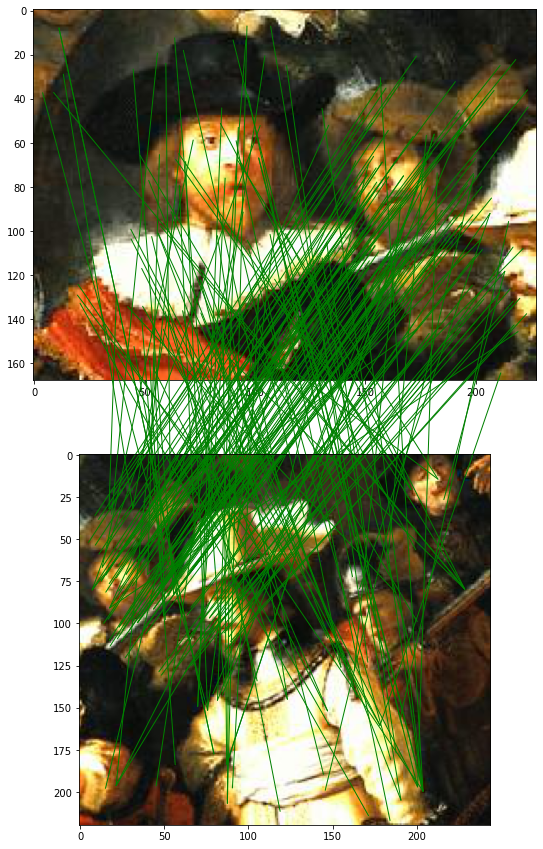

In [140]:
matcher = cv2.BFMatcher()
matches = matcher.match(d1,d2)
matches = sorted(matches, key = lambda x: x.distance)

draw_matches(f1, kp1, f2, kp2, matches[:200], figsize=(15,15), horizontal=False)

Observe that you see a lot of 'wrong' matches in the above images. But are they really wrong? What is happening? Why do we find these 'wrong' matches? And what do we mean with 'wrong' really? 

These 'wrong' matches will be filtered out in the next section. The filtering will *not* be done based on visual appearance but on the possibility to find a common mapping of points in image 1 to the corresponding points in image 2.

In case you are interested in algorithms and datastructures it might be interesting to realize that such a brute force approach to matching (essentially the problem of finding closest points in high dimensional space, in our case $\v d\in\setR^{256}$) is rather slow. It turns out that a faster search for the closest point is not trivial. In OpenCV an *approximate* but faster algorithm is available.

## Random Sample Concensus (RANSAC)

RANSAC is a method to simulatenously estimate the parameters of a transformation given examples of (input, output) pairs while at the same time removing those pairs that are not related by the model (the *outliers*).

The RANSAC algorithm needs two functions ``fit_model`` and ``test_model`` and proceeds as follows:

1. The ``fit_model`` function takes a randomly selected list of ``n_model_data`` (input, output) pairs and estimates the parameters of the model, so that the model maps each of the inputs as close as possible to the corresponding outputs. Most often ``n_model_data`` is takes to be the minimum number of (input, output) pairs that allow the parameters to be calculated.

1. The ``test_model`` function tests a given model on all available (input, output) pairs. It selects those pairs that fit the model quite good (a threshold to be set by the programmer, depending on what model is being used) as the *inliers*.

1. The functions ``fit_model`` and ``test_model`` are called ``n_iter`` times each time with a random choice of ``n_model_data`` (input, output) pairs. The model with the most inliers is taken to be the optimal model.

1. Finally, the model parameters are then estimated once more, not with just the ``n_model_data`` pairs, but with all inliers for this model.

Read about the RANSAC algorithm (e.g. on Wikipedia) and complete the ``ransac`` function below. To see the ``ransac`` function in action (if you have completed the code, or when you are looking for an example in what way to write the ``fit_model`` and ``test_model`` function look at the subsequent section on line fitting with RANSAC. (8pt)

Your RANSAC solution should be reasonably fast: the test cell below should run within a few seconds.

Note that RANSAC is agnostic about the model type used, as long as it is consistent between the data and the functions `fit_model` and `test_model`. This allows us to write it once and use it on a variety of problems: in this notebook, line fitting and image alignment.

In [141]:
def ransac(data, fit_model, test_model, test_model_pars, 
           n_model_data, n_iter):
    """
    Use of RANSAC to fit a model to data
    
    Parameters
    ==========
    
    data: list
       each item in data is a tuple (input, output)
    fit_model: callable
       a function that takes data (a list of tuples of 
       (input, output) pairs) and returns an object describing 
       the fitted model
    test_model: callable
       a function that takes as first parameter the model 
       (return value of fit_model) and as second argument a list
       of (input, output) tuples (it expects all data tuples 
       including those used for the estimation). 
       It returns an array with the indices in the list of tuples 
       (second parameter) of all data tuples that fit the model 
       (i.e. the inliers)
    test_model_pars: dict
       a dictionary that is passed to the ``test_model`` function used to set
       a threshold to determine if an (input, output) pair is an inlier or not.
    n_model_data: int
       the number of data tuples to be used to fit the model
    n_iter: int
       number of iterations 
    
    
    Return Value
    ============
    (model, inliers): tuple
       model: the model, as returned by fit_model
       inliers: the indices of the inliers of the returned model 
           (not just the data points used to fit the model)
    """
    count = 0
    max_error = test_model_pars['max_error']
    model = None
    indices = None
    inliers_list = []
    inliers_count = []
    
    while count < n_iter:
        d_len = len(data)
#         T = d_len/2
        randoms = set()
        while len(randoms) < n_model_data:
            randoms.add(np.random.randint(0,d_len))
     
        b_model = fit_model([data[index] for index in randoms])
        inliers = test_model(b_model, data, max_error=max_error)
        
        inliers_list.append(inliers)
        inliers_count.append(len(inliers))
        
#         if inliers.size > T:
#             new_inliers = []
#             for index in inliers:
#                 new_inliers.append(data[index])
#             better_model = fit_model(new_inliers)
#             inliers = test_model(better_model, data, max_error=max_error)
            
#             X = np.array([ x for x, _ in new_inliers])
#             Y = np.array([ y for _, y in new_inliers])
#             yp = better_model[0]*X + better_model[1]
#             error = np.sum(abs(Y - yp))/((Y).size)
            
#             if error < N:
#                 N = error
#                 model = better_model
#                 indices = inliers

        
        count += 1
        
    ix = np.argmax(inliers_count)
    indices = inliers_list[ix]
    opt_data = np.array([data[i] for i in indices])
    model = fit_model(opt_data)
    
    return (model, indices)


### Ransac for Line Fitting

Let's try the RANSAC algorithm on the line fitting problem. Note: fitting a line is NOT what is needed in the image stitching problem! We start with it because it is an easier problem and more easily visualized. 

First we generate some noisy data. We generate random  𝑥  values in the range from 0 to 10. The majority of those  𝑥  values get an  𝑦  value (to generate the pair  (𝑥,𝑦) ) that is on a straight line but with a random error. The remaining  𝑥  values are given a random  𝑦 -value.

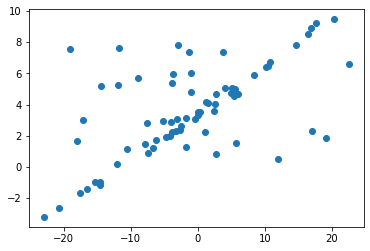

In [142]:
np.random.seed(7)
x = 10 * np.random.randn(70);
y = 0.3 * x + 3.4
y = y + 0.3 * np.random.randn(len(y))
y[40:] = 8 * np.random.rand(30)
plt.plot(x,y,'o');
data = list(zip(x,y)) # a list of pairs (input,output), 
                      # in this case (x,y) pairs

Given a number of $n>2$ pairs of points $(x,y)$ we can fit a line using a LSQ procedure:

In [143]:
def fit_line(data):
    """Fit a line to (x,y) pairs using a LSQ procedure"""
    X = np.array( [ [a, 1] for (a,b) in data])
    y = np.array( [ b for (a,b) in data])
    return np.linalg.lstsq(X, y, rcond=None)[0]

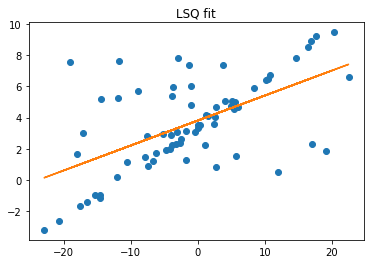

In [144]:
line_lsq = fit_line(data)
yfit_lsq = line_lsq[0]*x + line_lsq[1]
plt.plot(x,y,'o')
plt.plot(x,yfit_lsq)
plt.title('LSQ fit');

Evidently this is not the line we are looking for. We need to get rid of the outliers, i.e. the points $(x,y)$  that are not from the straight line. With the ``test_line`` function we can find the inliers for a given model.

In [145]:
def test_line(line, data, max_error=1):
    #print(data.shape)
    x = np.array( [ x for x, _ in data])
    y = np.array( [ y for _, y in data])
    yp = line[0]*x + line[1]
    err = np.abs(y-yp)
    inliers_idx = np.flatnonzero(err<max_error)
    return inliers_idx

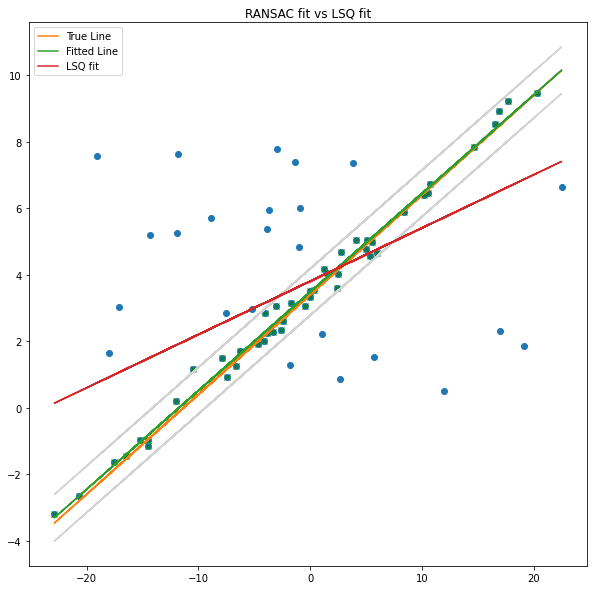

In [146]:
# Visual test (for the first test case below)

plt.figure(figsize=(10,10))
me = 0.7
line = None
inliers_idx = None
line, inliers_idx = ransac(data, fit_line, test_line, 
                           {'max_error':me}, 4, 1000)
plt.plot(x, y, 'o');
plt.plot(x[inliers_idx], y[inliers_idx], 'gx');
yfit = line[0]*x + line[1]
plt.plot(x, 0.3 * x + 3.4, label='True Line')
plt.plot(x,yfit, label='Fitted Line')
plt.plot(x,yfit+me, 'lightgray')
plt.plot(x,yfit-me, 'lightgray')
plt.plot(x,yfit_lsq, label='LSQ fit')
plt.legend()
plt.title('RANSAC fit vs LSQ fit');

In [147]:
np.random.seed(7)
x = 10 * np.random.randn(70);
y = 0.3 * x + 3.4
y = y + 0.3 * np.random.randn(len(y))
y[40:] = 8 * np.random.rand(30)
data = list(zip(x,y))
me = 0.7
line, inliers_idx = ransac(data, fit_line, test_line, 
                           {'max_error':me}, 4, 1000)
assert type(line) == np.ndarray, "Your model should be a numpy array, since that is what fit_model returns."
assert type(inliers_idx) == np.ndarray, "Your inliers should be given as a sorted numpy array."
assert np.isclose(line, np.array([0.3, 3.4]), atol=0.1, rtol=0.1).all(), \
    "Your line is not close to the line that generated the data."
assert len(set(inliers_idx) ^ set([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 51, 53, 55, 57])) <= 5, \
    "The inliers you report are not (nearly) the same as the ones you would expect."

np.random.seed(12)
x = 10 * np.random.randn(100);
y = -1.2 * x + 0.5
y = y + 0.3 * np.random.randn(len(y))
y[70:] = 8 * np.random.rand(30)
data = list(zip(x,y))
me = 0.7
line, inliers_idx = ransac(data, fit_line, test_line, 
                           {'max_error':me}, 4, 1000)
assert np.isclose(line, np.array([-1.2, 0.5]), rtol=0.1, atol=0.1).all()
assert len(set(inliers_idx) ^ set(range(70))) <= 8


### Find a Perspective Transform using Ransac

Remember where we are in the stitching process? We have found keypoints in the first and second image, collected in arrays ``kp1`` and ``kp2``. The matching pairs are encoded in the ``matches`` datastructure. First we are going to make a ``data`` list where each entry is of the form ``((x1, y1), (x2, y2))`` that is a tuple of two tuples encoding the position of matching keypoint coordinates in the first and second image.

In [148]:
data = [((kp1[m.queryIdx].pt), (kp2[m.trainIdx].pt)) for m in matches]

Next we need a ``fit_model`` and ``test_model`` function in order to use Ransac. The ``projective_fit_model`` function takes a set of point correspondences and finds the best projective matrix ``P`` that maps points (x1, y1) to (x2, y2).

In [149]:
def projective_fit_model(data):
    """data is a list (iterable) where each element is a tuple 
    ((x1,y1), (x2,y2)) of point correspondences. the data argument is
    a subset of the data matrix containing all point correspondences"""
    xy = []
    xaya = []
    for tuples in data:
        xy.append(tuples[0])
        xaya.append(tuples[1])
        
    return projective_transform_matrix(xy,xaya)

In [150]:
x = np.array([[1, 0], [0, 0], [0, 1], [2, 2]])
xa = np.array([[1, 1], [0, 1], [1, 2], [4, 3]])
mat = projective_fit_model(zip(x, xa))
assert type(mat) == np.ndarray
assert mat.shape == (3,3)
assert np.isclose(mat/mat[0][0], 
                  np.array([[1., 1., 0.], [0., 1., 1.], [0., 0., 1.]])).all()

eps = 1e-8
x = np.array([[1, 0], [0, 0], [0, 1], [2, 2], [4, 3]])
xa = np.array([[1, 1+eps], [0, 1-eps], [1, 2+eps], [4, 3-eps], [7, 4+eps]])
mat = projective_fit_model(zip(x, xa))
assert np.isclose(mat/mat[0][0], 
                  np.array([[1., 1., 0.], [0., 1., 1.], [0., 0., 1.]])).all()

In [151]:
from scipy.spatial import distance

def projective_test_model(P, data, max_error=2):
    """
    Finds indices of inliers in the data for projective transformation
    given by P, where the inliers are determined by the max_error.
    
    Parameters
    ==========
    
    P: numpy array
       a 3x3 matrix giving a projective transformation of the plane
    data: list
       each item in data is a tuple (input, output), each consisting
       of a point (numpy array with shape (2,)) in the plane.
    max_error: float 
       the maximum Euclidean distance between P(input) and output 
       for the pair (input, output) to count as an inlier
    
    Return Value
    ============
    inliers: numpy array
       the indices of the inliers in data, in order
    """
    indices = []
    for i in range(len(data)):
        In = np.asarray(data[i][0])
        Out = np.asarray(data[i][1])
        if distance.euclidean((h2e(P @ e2h(In))), Out) <= max_error:
            indices.append(i)
    return np.array(indices)

In [152]:
x = np.array([[-0.30099881,  0.34786734],
       [-0.43573294,  0.64231348],
       [-1.28532622,  1.13860487],
       [ 0.54744592,  0.51493255],
       [-0.20087976,  0.18980669],
       [-1.27066563, -0.20241131],
       [-0.64972417, -2.02646797],
       [-2.38189517, -0.1663487 ]])
xa = np.array([[ 0.369618  ,  0.67714101],
       [ 1.72259747, -0.04050429],
       [ 2.22190863, -1.06356781],
       [ 0.80900945, -2.48119838],
       [-0.53911635,  1.2555933 ],
       [ 0.07221467, -0.24165753],
       [-2.37579957,  0.87320773],
       [ 0.47265383, -0.59226317]])
P = np.array([[ 1.        , -1.8574528 ,  0.77686397],
                [-1.0861612 ,  0.63049228, -0.85821791],
                [ 1.01049866,  0.34736811, -0.27737639]])
assert np.array_equal(projective_test_model(P, list(zip(x, xa))), np.arange(8))
xa[::2, 0] += 1
xa[::4, 0] += 1
xa[::3, 1] += 1
xa[1::3, 1] += 1
assert np.array_equal(projective_test_model(P, list(zip(x, xa)), 0.5), np.array([5]))
assert np.array_equal(projective_test_model(P, list(zip(x, xa)), 1.1), np.array([1, 2, 3, 5, 7]))
assert np.array_equal(projective_test_model(P, list(zip(x, xa)), 2), np.array([1, 2, 3, 5, 6, 7]))
assert np.array_equal(projective_test_model(P, list(zip(x, xa)), 3), np.arange(8))


[[-1.42955129e+02  3.75832606e+01 -2.31739019e+04]
 [-3.97723666e+01 -1.55718234e+02  1.19259083e+03]
 [ 6.50926023e-02 -1.87148998e-02 -1.46289686e+02]]


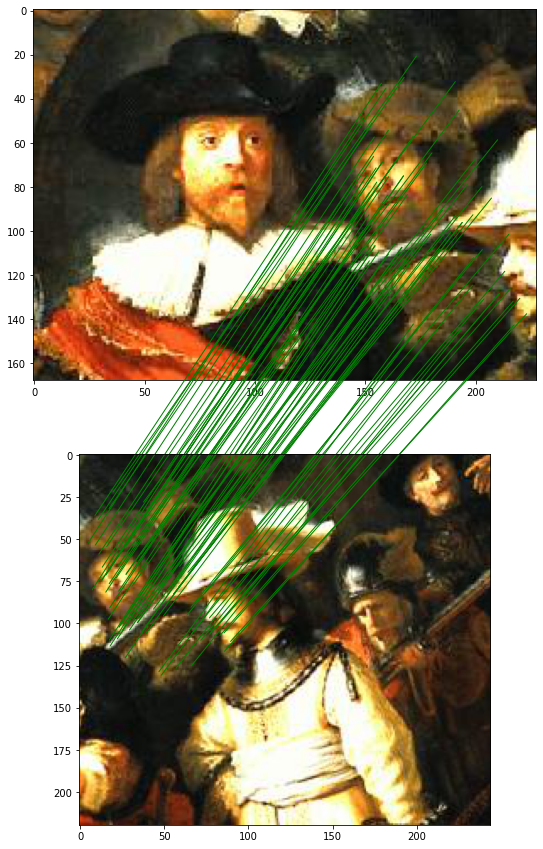

In [153]:
%matplotlib inline
P, inliers = ransac(data, projective_fit_model, 
                    projective_test_model, {'max_error':1}, 4, 1000) 
print(np.linalg.inv(P))
draw_matches(f1, kp1, f2, kp2, np.array(matches)[inliers], 
             horizontal=False)

## Stitching it all together

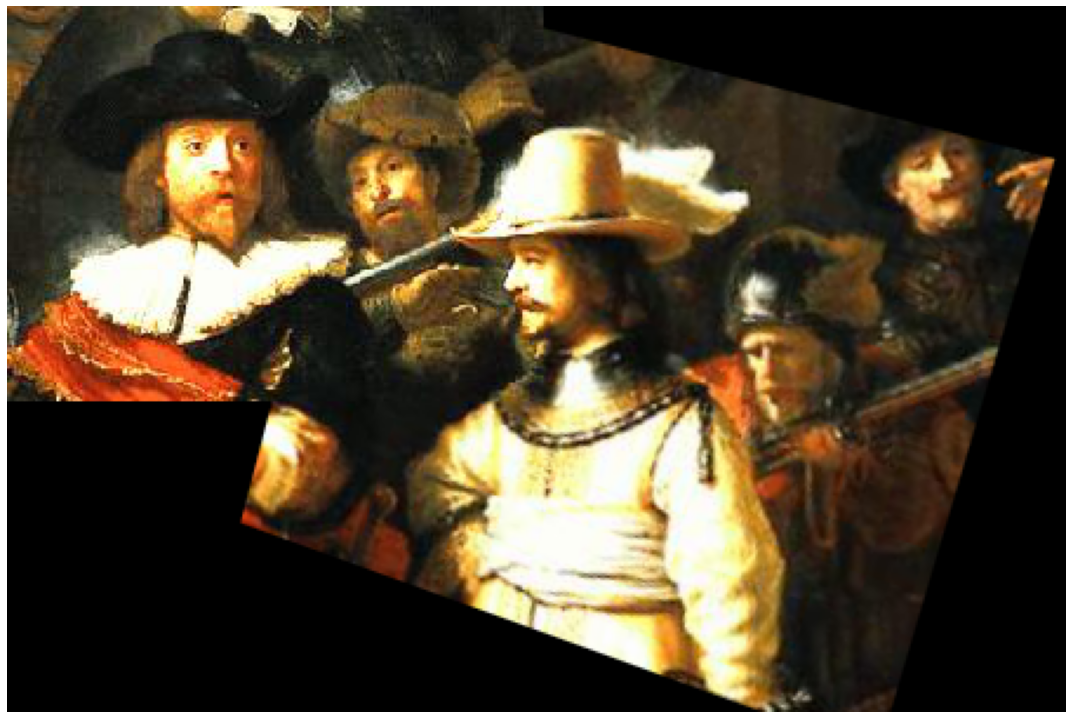

In [154]:
plt.figure(figsize=(15,15))
f_stitched = warp(f2, P, output_shape=(300,450), preserve_range=True).astype(np.uint8)
M, N = f1.shape[:2]
f_stitched[:M, :N, :] = f1
plt.imshow(f_stitched);
plt.axis('off');
plt.tight_layout()